In [113]:
import mysql.connector
import pandas as pd
import math
import numpy as np
import seaborn as sns

In [114]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow import keras

print(tf.__version__)

2.7.0


In [115]:
#Data Processing:
#Pull data realted to tournament result, course, strookes gained
print("Please enter Password to access database")
pwd_in = input()

db = mysql.connector.connect(
    host = "localhost",
    user = "root",
    passwd = pwd_in,
    database = "golf")

mycursor = db.cursor(buffered=True)

mycursor.execute("SELECT Finishing_pos, SG_OFF_TEE, SG_APPROACH, SG_AROUND, SG_PUTT FROM standings_new")
pull_1 = mycursor.fetchall()


Please enter Password to access database


In [116]:
#Data Processing:
#Remove invalid results from database. Remove results of Cut/WD players( who have 999 results)
data=[]
for i in range(len(pull_1)):
    if (pull_1[i][0] != 999 and pull_1[i][1] != 999 and pull_1[i][2] != 999 and pull_1[i][3] != 999 and pull_1[i][4] != 999) and (pull_1[i][0] != 0 and pull_1[i][1] != 0 and pull_1[i][2] != 0 and pull_1[i][3] != 0 and pull_1[i][4] != 0) :
        data.append(pull_1[i][:])

In [117]:
print('Length of pull_1:',len(pull_1))
print('Length of proper data:',len(data))
print('Percent of data retained:', len(data)/len(pull_1))

Length of pull_1: 91312
Length of proper data: 47802
Percent of data retained: 0.5235018398458035


In [118]:
columns = ['Result', 'SG Off Tee', 'SG Approach', 'SG Around Green', 'SG Putt']
df_data = pd.DataFrame(data, columns= columns)
print(df_data)

       Result  SG Off Tee  SG Approach  SG Around Green  SG Putt
0           1       0.788        1.523            0.451    1.191
1           2       1.064        0.751            0.044    2.095
2           3       0.741        0.357            1.641    0.465
3           5       0.142        0.830            0.527    1.204
4           5       0.787        1.427            0.945   -0.456
...       ...         ...          ...              ...      ...
47797      63       0.448       -0.333           -0.891    0.149
47798      66       0.238        0.951           -0.536   -1.529
47799      67       0.510        0.453           -1.233   -0.858
47800      68      -0.384       -0.050           -0.344   -0.599
47801      69      -1.418       -1.283            0.217   -0.393

[47802 rows x 5 columns]


In [119]:
train_dataset = df_data.sample(frac=0.8, random_state = 0)
test_dataset = df_data.drop(train_dataset.index)
print(len(df_data))
print(len(train_dataset))
print(len(test_dataset))

47802
38242
9560


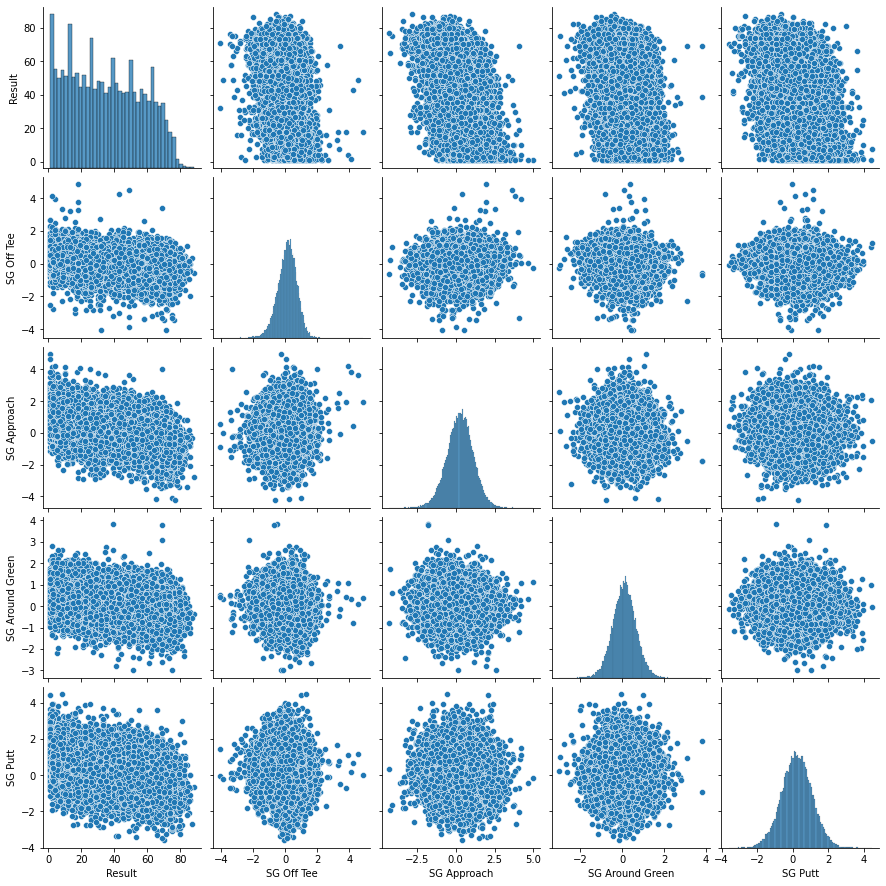

In [120]:
sns.pairplot(train_dataset)

In [124]:
# As can be seen there is a small correlation between each of the SG data and the tournament placement. The 'tightest' seems to be driving distance, however, this seems to have not much affect (small slope)
# It appears that possible the strongest effect is with SG Approach, followed by SG Around the green
train_dataset.describe()

,Result,SG Off Tee,SG Approach,SG Around Green,SG Putt
count,38242.000000,38242.000000,38242.000000,38242.000000,38242.000000
mean,34.712437,0.124589,0.279745,0.108194,0.245434
std,21.404856,0.612157,0.867008,0.565101,0.872735
min,1.000000,-4.081000,-4.268000,-3.001000,-3.603000
25%,16.000000,-0.249000,-0.276750,-0.257000,-0.331000
50%,33.000000,0.157000,0.296000,0.111000,0.245000
75%,53.000000,0.532750,0.847000,0.473000,0.820000
max,88.000000,4.870000,4.963000,3.823000,4.477000


In [128]:
#split the features from the labels. The features here are the SG values and the label is the tournament results
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Result')
test_labels = test_features.pop('Result')

In [129]:
#The normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

[[0.12458874 0.27974445 0.10819371 0.24543367]]


In [132]:
first= np.array(train_features[:1])

with np.printoptions(precision=2,suppress = True):
    print('First Example', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First Example [[0.69 0.14 0.17 1.31]]

Normalized: [[ 0.93 -0.16  0.1   1.22]]


In [133]:
# a multiple input linear regression model:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [135]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss = 'mean_absolute_error'
)

In [137]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2
)

CPU times: total: 2min 45s
Wall time: 1min 46s


In [140]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,val_loss,epoch
0,12.043418,7.561518,0
1,7.491951,7.558146,1
2,7.491135,7.552418,2
3,7.491966,7.556069,3
4,7.494175,7.560441,4
...,...,...,...
95,7.490569,7.570505,95
96,7.492427,7.585492,96
97,7.494042,7.565277,97
98,7.495302,7.548463,98


In [144]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Rank]')
  plt.legend()
  plt.grid(True)

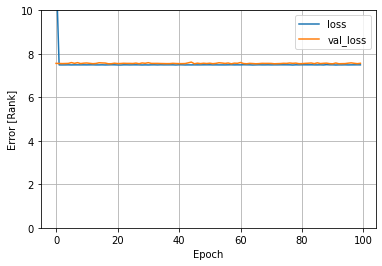

In [145]:
plot_loss(history)

In [147]:
test_results ={}

test_results['multi-input linear model'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0
)

In [163]:
x= (2,0.68,0,0)
y = linear_model.predict(x)
print(y)

[[1.5813217]]


In [164]:
# A Deep Nueral Network Model
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [166]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_4 (Dense)             (None, 64)                320       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [167]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 3min 37s
Wall time: 2min 13s


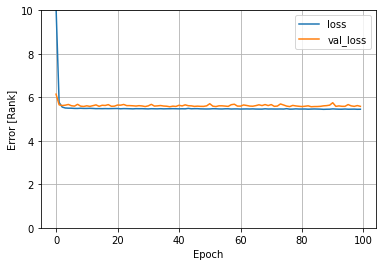

In [168]:
plot_loss(history)

In [169]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [170]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
multi-input linear model,7.429857
dnn_model,5.348353


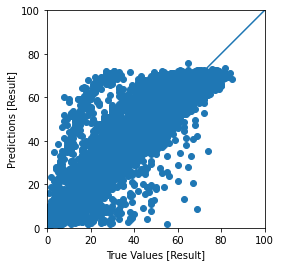

In [176]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Result]')
plt.ylabel('Predictions [Result]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

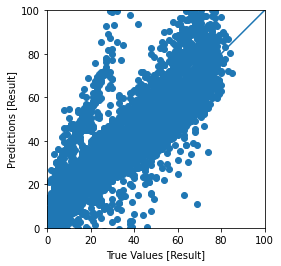

In [178]:
test_predictions = linear_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Result]')
plt.ylabel('Predictions [Result]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [177]:
x = (2,0.68,0,0)
y_lin = linear_model.predict(x)
print(y_lin)


y_dnn = dnn_model.predict(x)
print(y_dnn)

[[1.5813217]]
[[5.2318225]]
